## Imports

In [9]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning # Ignoring convergence warnings (not necessarily required, but makes terminal more readable)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore") # As to not clutter the terminal with warnings

## Model Implementation

In [10]:
# Define models and hyperparameter spaces in one dictionary. Easier to access and makes code more readable
models = {
    # Just using the suggested values here from the rubric
    "Logistic Regression": (LogisticRegression(max_iter=2000), {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['liblinear', 'saga']
    }),
    "Decision Tree": (DecisionTreeClassifier(), {
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }),
    "Random Forest": (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }),
    "Gaussian NB": (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    }),
    "SVM": (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1]
    }),
    "KNN": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }),
    "AdaBoost": (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }),
    "Gradient Boost": (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }),
    "XGBoost": (xgb.XGBClassifier(eval_metric='mlogloss'), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }),
    "ANN": (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    })
}

summary_results = []  # List to store the results of each model
feature_files = [f"Feature_W{w}_Olap{o}.csv" for w in [100, 200, 300, 400, 500] for o in [0, 50]]  # List of feature files to process
base_path = "./data"  # Path to feature files
# ChatGPT came up with this idea to make it more guaranteed that each is used at least once
used_kfold_once = False  # Flag to track if KFold cross-validation has been used once
used_stratkfold_once = False  # Flag to track if StratifiedKFold cross-validation has been used once


## Hyperparameter Tuning and Cross Validation

In [11]:
# Loop through each feature file
for file in feature_files:
    path = os.path.join(base_path, file)  # Make path
    if not os.path.exists(path):  # Check if file exists
        print(f"File not found: {file}")
        continue  # Skip to next file if this one is not found

    df = pd.read_csv(path)  # Read the CSV file into a Pandas DataFrame
    X = df.drop(columns=["activity_type", "expID", "window_size", "overlap", "start_index"])  # Drop non-feature columns
    y = df["activity_type"]  # Target variable (activity type)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    label_names = label_encoder.classes_
    X_scaled = StandardScaler().fit_transform(X)  # Scale the features

    # Loop through different test set sizes
    for test_size in [0.2, 0.3]:
        split_label = "80/20" if test_size == 0.2 else "70/30"  # Label if I want 80/20 or 70/30 split
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=test_size, stratify=y_encoded, random_state=42  # Split data into training and testing sets
        )

        # Loop through each model
        for name, (model, params) in models.items():
            # Determine cross-validation method
            if not used_stratkfold_once:  # Use StratifiedKFold for the first time
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Stratified K-Fold cross-validator
                used_stratkfold_once = True
                cv_type = "StratifiedKFold"
            elif not used_kfold_once:  # Use KFold for the second time
                cv = KFold(n_splits=5, shuffle=True, random_state=42)  # K-Fold cross-validator
                used_kfold_once = True
                cv_type = "KFold"
            else:  # Use StratifiedKFold for the rest
                cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                cv_type = "StratifiedKFold"

            # Perform Randomized Search Cross-Validation for hyperparameter tuning
            grid = RandomizedSearchCV(
                estimator=model,  
                param_distributions=params,  
                n_iter=5,  
                cv=cv,  
                scoring='accuracy',  
                n_jobs=-1,  
                random_state=42  
            )
            grid.fit(X_train, y_train)  # Fit RandomizedSearchCV
            best_model = grid.best_estimator_  # Get the best model from search
            y_pred = best_model.predict(X_test)  # Make predictions on test set
            y_proba = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None  # Get predicted probabilities

            # Calculate relevant values
            acc = accuracy_score(y_test, y_pred)  
            prec = precision_score(y_test, y_pred, average='weighted')  
            rec = recall_score(y_test, y_pred, average='weighted')  
            f1 = f1_score(y_test, y_pred, average='weighted')  
            roc = roc_auc_score(y_test, y_proba, multi_class='ovr') if y_proba is not None else None  

            # Do cross-validation to get average performance values
            cv_scores = cross_validate(best_model, X_scaled, y_encoded, cv=cv, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
            acc_cv = cv_scores['test_accuracy'].mean()  # Mean CV accuracy
            prec_cv = cv_scores['test_precision_weighted'].mean()  # Mean CV precision
            rec_cv = cv_scores['test_recall_weighted'].mean()  # Mean CV recall
            f1_cv = cv_scores['test_f1_weighted'].mean()  # Mean CV F1-score

            class_report = classification_report(y_test, y_pred, output_dict=True)  # Classification report
            conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion matrix

            # Store results in summary list
            summary_results.append({
                'Feature File': file,
                'Model': name,
                'Split': split_label,
                'CV Type': cv_type,
                'Best Params': grid.best_params_,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC AUC': roc,
                'CV Accuracy': acc_cv,
                'CV Precision': prec_cv,
                'CV Recall': rec_cv,
                'CV F1 Score': f1_cv,
                'Classification Report': class_report,
                'Confusion Matrix': conf_matrix
            })


## Summary / Evaluation & Metrics

In [12]:
# Display and save final summary
summary_df = pd.DataFrame(summary_results)  # Convert summary list to DataFrame
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 100)  
print("\nFinal Summary (Top 20 Rows):")
print(summary_df.head(20))  # Print first 20 rows of summary
csv_path = "./final_model_summary.csv"  # Path to save summary CSV
summary_df.to_csv(csv_path, index=False)  # Save summary to a CSV file
print(f"Full results saved to: {csv_path}")  # Print save path


Final Summary (Top 20 Rows):
              Feature File                Model  Split          CV Type  \
0   Feature_W100_Olap0.csv  Logistic Regression  80/20  StratifiedKFold   
1   Feature_W100_Olap0.csv        Decision Tree  80/20            KFold   
2   Feature_W100_Olap0.csv        Random Forest  80/20  StratifiedKFold   
3   Feature_W100_Olap0.csv          Gaussian NB  80/20  StratifiedKFold   
4   Feature_W100_Olap0.csv                  SVM  80/20  StratifiedKFold   
5   Feature_W100_Olap0.csv                  KNN  80/20  StratifiedKFold   
6   Feature_W100_Olap0.csv             AdaBoost  80/20  StratifiedKFold   
7   Feature_W100_Olap0.csv       Gradient Boost  80/20  StratifiedKFold   
8   Feature_W100_Olap0.csv              XGBoost  80/20  StratifiedKFold   
9   Feature_W100_Olap0.csv                  ANN  80/20  StratifiedKFold   
10  Feature_W100_Olap0.csv  Logistic Regression  70/30  StratifiedKFold   
11  Feature_W100_Olap0.csv        Decision Tree  70/30  StratifiedKFol

## Visualization

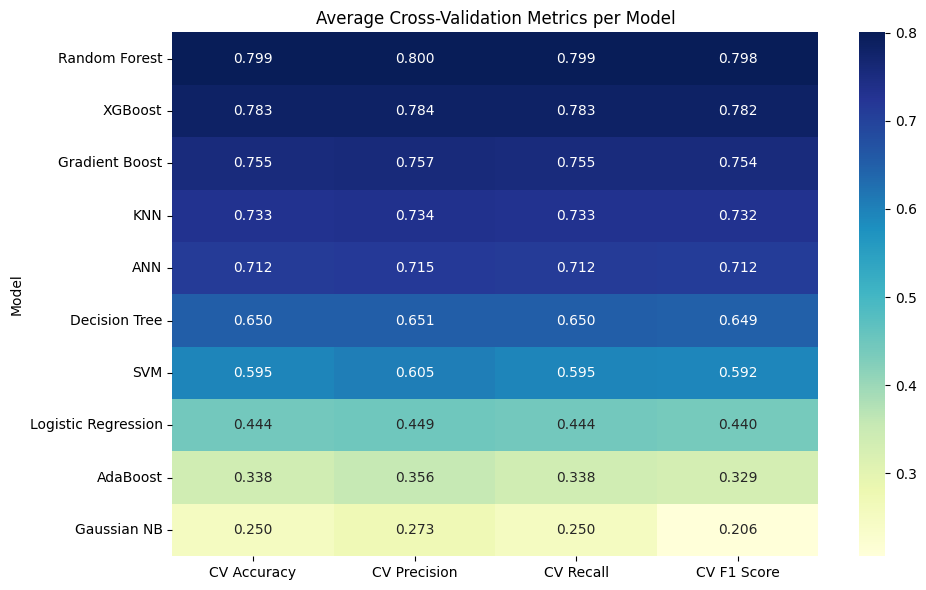

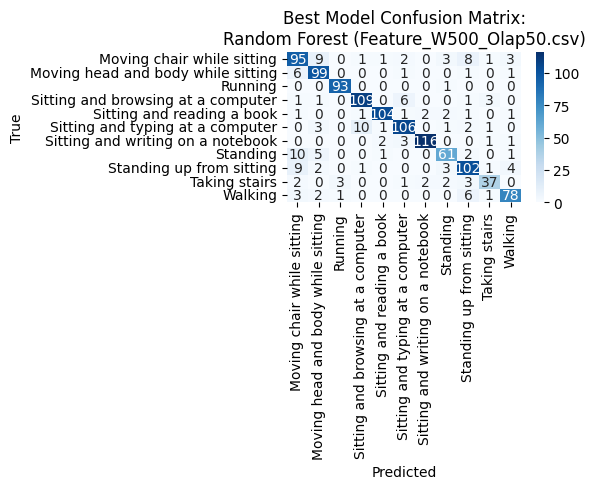

In [13]:
# Average CV scores heatmap
summary_avg = summary_df.groupby("Model")[["CV Accuracy", "CV Precision", "CV Recall", "CV F1 Score"]].mean().sort_values("CV Accuracy", ascending=False)
plt.figure(figsize=(10, 6))
sns.heatmap(summary_avg, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Average Cross-Validation Metrics per Model")
plt.tight_layout()
plt.show()

# Confusion matrix for best model overall
best_result = summary_df.loc[summary_df["CV Accuracy"].idxmax()]
best_matrix = best_result["Confusion Matrix"]
plt.figure(figsize=(6, 5))
sns.heatmap(best_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title(f"Best Model Confusion Matrix:\n{best_result['Model']} ({best_result['Feature File']})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()